# Essais de réseaux de neurones pour le projet

In [24]:
import gzip
import time
import numpy
import numpy as np
import shutil
import scipy.constants as cst
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.autograd import Variable

from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
import torchvision.transforms as T
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib
matplotlib.rcParams['figure.figsize'] = (30, 20)
from matplotlib import pyplot as plt
import os
import cmath
import pickle

j = cmath.sqrt(-1)



In [188]:
donnees = torch.load('donnees.pt')
print(donnees[0])

tensor([5.7000e+00, 3.1510e+03, 1.0982e+04], dtype=torch.float64)


In [8]:
nom_pickle = 'mega_dStruct.pickle'
def chargementPickle(pfxPickle="",silencieux=False):
	r"""
	\brief
	Recharge dictionnaire de données structurées depuis fichier binaire.

	\param[in] silencieux
	Si vrai, alors ne pas imprimer de message; si faux, alors
	imprimer message qui avertit l'usager que la recharge depuis
	fichier binaire est effectuée.

	\return
	Dictionnaire de données structurées dont la structure est
	définie dans la documentation de enregistrementPickle().
	"""
	if not silencieux:
		print("CHARGEMENT DEPUIS FORMAT BINAIRE PICKLE")
	nomFichier = nom_pickle

	with open(nomFichier, 'rb') as fichierPkl:
	    dicoDonneesRechargees = pickle.load(fichierPkl)

	return dicoDonneesRechargees
data = chargementPickle()

CHARGEMENT DEPUIS FORMAT BINAIRE PICKLE


In [33]:
## UTILS
def compute_numerical_derivative3(x, y):
    res = np.zeros_like(y) # 'd' for double
    # centered differences
    x_dif = x[2:] - x[:-2]
    y_dif = y[2:] - y[:-2]
    res[1:-1] = y_dif / x_dif
    res[0] = (y[1] - y[0]) / (x[1] - x[0])
    res[-1] = (y[-1] - y[-2]) / (x[-1] - x[-2])
    return res
def wrap_angle(unwrapped_phase):
    return np.angle(np.exp(1j*unwrapped_phase))

def get_number_params(model):
    s = 0
    params = model.parameters()
    for p in params:
        ss=1
        for u in p.shape:
            ss = u*ss      
        s +=ss
    return s

In [158]:
## DATASET 
class CDCDataset(Dataset):
    def __init__(self, path, set_type="train"):
        super().__init__()
        # garde les paramètres en mémoire
        self.path = path
        # charger les données
        self.tx1 = torch.load('tX1.pt')
        self.tx2 = torch.load('tX2.pt')
        self.ty = torch.load('ty.pt')
        
        dataset_size = len(self.ty)
        self.lambda_ = np.linspace(1500e-9,1600e-9,1001)
        self.omega = 2*np.pi*cst.c/self.lambda_ 
        yi = torch.Tensor(self.tx1.shape[0],int(self.tx1.shape[1]/2))
        yr = torch.Tensor(self.tx1.shape[0],int(self.tx1.shape[1]/2))
        y_reshape = torch.reshape(self.tx1,(self.tx1.shape[0],2,int(self.tx1.shape[1]/2)))
        yr[:,:] = y_reshape[:,0,:]
        yi[:,:] = y_reshape[:,1,:]

        x = torch.Tensor(self.tx2.shape[0],3,int(self.tx2.shape[1]/2-1))
        x_reshape = torch.reshape(self.tx2,(len(self.ty),2,101))
        x[:,0,:] = ((x_reshape[:,0,:-1])/50000)
        x[:,1,:] = (((x_reshape[:,1,:-1])-torch.min(x_reshape[:,1,:-1]))/(torch.max(x_reshape[:,1,:-1])-torch.min(x_reshape[:,1,:-1])))
        x[:,2,:] = (self.ty[:,1]/torch.max(self.ty[:,1])).unsqueeze(-1).expand(len(self.ty),100)       
        X = []
        Y = []
        Y2 = []
        angle = []
        self.data =[] 
        
        
        for i in range(dataset_size): 
            angle.append(torch.Tensor(np.unwrap(np.angle(yr[i,:].cpu().numpy()+1j*yi[i,:].cpu().numpy()),discont=cst.pi)))
            X.append(x[i])# D.append(X2[i].unsqueeze(0))
            y=10*np.log10(np.abs(yi[i,:]**2+yr[i,:]**2))
            Y.append(10*np.log10(np.abs(yi[i,:]**2+yr[i,:]**2)))#     U.append(10*np.log10(np.abs(Y2[i,:])**2))      
            self.data .append([x[i],y]) #Data.append([X2[i].unsqueeze(0),Y2[i,:]]) #
            Y2.append(torch.stack([Y[i],angle[i]],0).view(2002))
        indices = list(range(dataset_size))
        split = int(np.floor(0.25 * dataset_size))
        np.random.seed(3)
        np.random.shuffle(indices)
        train_indices, test_indices = indices[split:], indices[:split]
        
        
        if set_type is "train":        
            self.angle = [angle[i] for i in train_indices]
            self.X = [X[i] for i in train_indices]
            self.Y = [Y[i] for i in train_indices]
            self.Y2 = [Y2[i] for i in train_indices]
        elif set_type is "test":
            self.angle = [angle[i] for i in test_indices]
            self.X = [X[i] for i in test_indices]
            self.Y = [Y[i] for i in test_indices] 
            self.Y2 = [Y2[i] for i in test_indices]
    def __getitem__(self, index):
        X = self.X[index]
        Y = self.Y2[index]
        return X,Y   
    def __len__(self):
        # TODO Q1A
        return len(self.Y)


In [35]:
## CLASS POUR DENSENET
class DenseBlock(nn.Module):
    def __init__(self, in_channels):
        super(DenseBlock, self).__init__() 
        self.relu = nn.LeakyReLU(inplace = True)
        self.bn = nn.BatchNorm1d(num_features = in_channels)
        self.conv1 = nn.ConvTranspose1d(in_channels = in_channels, out_channels = 32, 
                                        kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.ConvTranspose1d(in_channels = 32, out_channels = 32, 
                                        kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = nn.ConvTranspose1d(in_channels = 64, out_channels = 32, 
                                        kernel_size = 3, stride = 1, padding = 1)
        self.conv4 = nn.ConvTranspose1d(in_channels = 96, out_channels = 32, 
                                        kernel_size = 3, stride = 1, padding = 1)
        self.conv5 = nn.ConvTranspose1d(in_channels = 128, out_channels = 32, 
                                        kernel_size = 3, stride = 1, padding = 1)  
    def forward(self, x):
        batch_size = x.shape[0]
        bn = self.bn(x)
        conv1 = self.relu(self.conv1(bn))
        conv2 = self.relu(self.conv2(conv1))
        c2_dense = self.relu(torch.cat([conv1, conv2], 1))
        conv3 = self.relu(self.conv3(c2_dense))
        c3_dense = self.relu(torch.cat([conv1, conv2, conv3], 1))
        conv4 = self.relu(self.conv4(c3_dense))
        c4_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4], 1)) 
        conv5 = self.relu(self.conv5(c4_dense))
        c5_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5], 1))
        x = c5_dense

        return x 
class Transition_Layer(nn.Module):
    def __init__(self, in_channels, out_channels): 
        super(Transition_Layer, self).__init__()   
        self.relu = nn.ReLU(inplace = True)
        self.bn = nn.BatchNorm1d(out_channels)
        self.conv = nn.ConvTranspose1d(in_channels = in_channels, out_channels = out_channels, 
                                       kernel_size = 1, bias = False) 
        self.avg_pool = nn.AvgPool1d(kernel_size = 2, stride = 2, padding = 0) 
    def forward(self, x):
        bn = self.bn(self.relu(self.conv(x)))
        out = self.avg_pool(bn) 
        return bn   



In [36]:
class DenseNet(nn.Module): 
    def __init__(self, nr_classes,batch_size): 
        super(DenseNet, self).__init__()
        self.batch_size = batch_size
        self.lowconv = nn.Conv1d(in_channels = 3, out_channels = 64, kernel_size = 7, padding = 3, bias = False) 
        self.relu = nn.ReLU()
        # Make Dense Blocks 
        self.denseblock1 = self._make_dense_block(DenseBlock, 64) 
        self.denseblock2 = self._make_dense_block(DenseBlock, 128)
        self.denseblock3 = self._make_dense_block(DenseBlock, 128)    # Make transition Layers 
        self.transitionLayer1 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 128) 
        self.transitionLayer2 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 128) 
        self.transitionLayer3 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 64)    # Classifier 
        self.bn = nn.BatchNorm1d(num_features = 64)
        self.fc1 = nn.Sequential(nn.Linear(64*100,32),
                                 nn.ReLU(),
#                                  nn.Linear(32,100),
#                                  nn.ReLU(),
                                 nn.Linear(32,nr_classes))
        self.fc2 = nn.Sequential(nn.Linear(64*100,100),
                                 nn.ReLU(),
                                 nn.Linear(100,nr_classes))
    def _make_dense_block(self, block, in_channels): 
        layers = [] 
        layers.append(block(in_channels)) 
        return nn.Sequential(*layers)   
    def _make_transition_layer(self, layer, in_channels, out_channels): 
        modules = [] 
        modules.append(layer(in_channels, out_channels)) 
        return nn.Sequential(*modules)   
    def forward(self, x): 
        batch_size = x.shape[0]
        out = self.relu(self.lowconv(x))
        out = self.denseblock1(out)
        out = self.transitionLayer1(out)
        out = self.denseblock2(out) 
        out = self.transitionLayer2(out) 
        out = self.denseblock3(out) 
        out = self.transitionLayer3(out) 
        out = self.bn(out) 
#         plt.figure(1)
#         plt.imshow(out[0,:].cpu().detach().numpy()) 
#         out = stop
        out = out.view(batch_size,64*100,-1).mean(dim=1) ### pas sur de ce que fait .mean(dim=2)
#         plt.plot(out[0,:].cpu().detach().numpy())      
        out1 = self.fc1(out)
        out2 = self.fc2(out)

        return out1,out2

In [164]:
class DenseNet2(nn.Module): 
    def __init__(self, nr_classes,batch_size,outTL,HL): 
        super(DenseNet2, self).__init__()
        self.lowconv = nn.Conv1d(in_channels = 3, out_channels = 32,
                                 kernel_size = 3, padding = 1, bias = False) 
        self.relu = nn.ReLU()
        self.outTL = outTL
        self.HL = HL
        self.batch_size = batch_size

        # Make Dense Blocks 
        self.denseblock1 = self._make_dense_block(DenseBlock, 32)
        self.denseblock2 = self._make_dense_block(DenseBlock, 64)
        # Make transition Layers 
        self.transitionLayer1 = self._make_transition_layer(Transition_Layer, in_channels = 160, 
                                                            out_channels = 64)
        self.transitionLayer2 = self._make_transition_layer(Transition_Layer, in_channels = 160, 
                                                            out_channels = self.outTL) 

        self.bn = nn.BatchNorm1d(num_features = self.outTL)
        self.fc1 = nn.Sequential(nn.ReLU(),
                                 nn.Linear(self.outTL*100,self.HL),
                                 nn.ReLU(),
                                 nn.Linear(self.HL,nr_classes))
        
        self.fc2 = nn.Sequential(nn.ReLU(),
                                 nn.Linear(self.outTL*100,self.HL),
                                 nn.ReLU(),
                                 nn.Linear(self.HL,nr_classes))
        
    def _make_dense_block(self, block, in_channels): 
        layers = [] 
        layers.append(block(in_channels)) 
        return nn.Sequential(*layers)   
    def _make_transition_layer(self, layer, in_channels, out_channels): 
        modules = [] 
        modules.append(layer(in_channels, out_channels)) 
        return nn.Sequential(*modules)   
    def forward(self, x): 
        batch_size = x.shape[0]
        out = self.relu(self.lowconv(x))
#         print(out.shape)
#         out = stop
        out = self.denseblock1(out)
        out = self.transitionLayer1(out)
        out = self.denseblock2(out) 
        out = self.transitionLayer2(out) 
        out = self.bn(out)
#         plt.figure(1)
#         plt.imshow(out[0,:].cpu().detach().numpy())
#         out = stop
        out = out.view(batch_size,100*256,-1).mean(dim=2) ### pas sur de ce que fait .mean(dim=2)
#         out = out.view(batch_size*100*100) ### pas sur de ce que fait .mean(dim=2)
#         plt.plot(out[0,:].cpu().detach().numpy())
#         out = stop
        out1 = self.fc1(out)
        out2 = self.fc2(out)
        return out1,out2

In [155]:
class DenseNet1(nn.Module): 
    def __init__(self, nr_classes,batch_size,outTL,HL): 
        super(DenseNet1, self).__init__()
        self.lowconv = nn.Conv1d(in_channels = 3, out_channels = 32,
                                 kernel_size = 3, padding = 1, bias = False) 
        self.relu = nn.ReLU()
        self.outTL = outTL
        self.HL = HL
        # Make Dense Blocks 
        self.denseblock1 = self._make_dense_block(DenseBlock, 32)   
        # Make transition Layers 
        self.transitionLayer1 = self._make_transition_layer(Transition_Layer, in_channels = 160, 
                                                            out_channels = self.outTL) 
        self.bn = nn.BatchNorm1d(num_features = self.outTL)
        self.fc1 = nn.Sequential(nn.ReLU(),
                                 nn.Linear(self.outTL*100,self.HL),
                                 nn.ReLU(),
                                 nn.Linear(self.HL,nr_classes))
        
        self.fc2 = nn.Sequential(nn.ReLU(),
                                 nn.Linear(self.outTL*100,self.HL),
                                 nn.ReLU(),
                                 nn.Linear(self.HL,nr_classes))
        self.fc11 = nn.Sequential(nn.ReLU(),
                                 nn.Linear(nr_classes,2*self.HL),
                                 nn.ReLU(),
                                 nn.Linear(2*self.HL,nr_classes))
    
        self.fc22 = nn.Sequential(nn.ReLU(),
                                 nn.Linear(nr_classes,2*self.HL),
                                 nn.ReLU(),
                                 nn.Linear(2*self.HL,nr_classes)) 
        
    def _make_dense_block(self, block, in_channels): 
        layers = [] 
        layers.append(block(in_channels)) 
        return nn.Sequential(*layers)   
    def _make_transition_layer(self, layer, in_channels, out_channels): 
        modules = [] 
        modules.append(layer(in_channels, out_channels)) 
        return nn.Sequential(*modules)   
    def forward(self, x): 
        batch_size = x.shape[0]
        out = self.relu(self.lowconv(x))
#         print(out.shape)
#         out = stop
        out = self.denseblock1(out)
        out = self.transitionLayer1(out)     
        out = self.bn(out)
#         plt.figure(1)
#         plt.imshow(out[0,:].cpu().detach().numpy())
#         out = stop
        out = out.view(batch_size,self.outTL*100,-1).mean(dim=2) ### pas sur de ce que fait .mean(dim=2)
#         out = out.view(batch_size*100*100) ### pas sur de ce que fait .mean(dim=2)
#         plt.plot(out[0,:].cpu().detach().numpy())
#         out = stop

        out1 = self.fc1(out)
        out1 = self.fc11(out1)
        out2 = self.fc2(out)
        out2 = self.fc22(out2)
        return out1,out2

In [44]:
class DenseNet1_(nn.Module): 
    def __init__(self, nr_classes,batch_size,outTL,HL): 
        super(DenseNet1_, self).__init__()
        self.lowconv = nn.Conv1d(in_channels = 3, out_channels = 32,
                                 kernel_size = 3, padding = 1, bias = False) 
        self.relu = nn.ReLU()
        self.outTL = outTL
        self.HL = HL
        # Make Dense Blocks 
        self.denseblock1 = self._make_dense_block(DenseBlock, 32)   
        # Make transition Layers 
        self.transitionLayer1 = self._make_transition_layer(Transition_Layer, in_channels = 160, 
                                                            out_channels = self.outTL) 
        self.bn = nn.BatchNorm1d(num_features = self.outTL)

        self.fc2 = nn.Sequential(nn.ReLU(),
                                 nn.Linear(self.outTL*100,self.HL),
                                 nn.ReLU(),
                                 nn.Linear(self.HL,nr_classes))

        self.fc1 = nn.Sequential(nn.ReLU(),
                                 nn.Linear(self.outTL*100,nr_classes))         
        self.fc2 = nn.Sequential(nn.ReLU(),
                                 nn.Linear(self.outTL*100,nr_classes)) 
        self.fc11 = nn.Sequential(nn.ReLU(),
                                 nn.Linear(nr_classes,self.HL),
                                 nn.ReLU(),
                                 nn.Linear(self.HL,nr_classes))
    
        self.fc22 = nn.Sequential(nn.ReLU(),
                                 nn.Linear(nr_classes,self.HL),
                                 nn.ReLU(),
                                 nn.Linear(self.HL,nr_classes)) 
        
    def _make_dense_block(self, block, in_channels): 
        layers = [] 
        layers.append(block(in_channels)) 
        return nn.Sequential(*layers)   
    def _make_transition_layer(self, layer, in_channels, out_channels): 
        modules = [] 
        modules.append(layer(in_channels, out_channels)) 
        return nn.Sequential(*modules)   
    def forward(self, x): 
        batch_size = x.shape[0]
        
        out = self.relu(self.lowconv(x))
#         print(out.shape)
#         out = stop
        out = self.denseblock1(out)
        out = self.transitionLayer1(out)     
        out = self.bn(out)
#         plt.figure(1)
#         plt.imshow(out[0,:].cpu().detach().numpy())
#         out = stop
        out = out.view(batch_size,out.shape[2]*out.shape[1],-1).mean(dim=2) ### pas sur de ce que fait .mean(dim=2)
#         out = out.view(batch_size*100*100) ### pas sur de ce que fait .mean(dim=2)
#         plt.plot(out[0,:].cpu().detach().numpy())
#         out = stop

        out1 = self.fc1(out)
        out1 = self.fc11(out1)
        out2 = self.fc2(out)
        out2 = self.fc22(out2)
        return out1,out2

In [83]:
class NET(nn.Module): 
    def __init__(self, nr_classes,batch_size,outTL,HL): 
        super(NET, self).__init__()
        self.outTL = outTL
        self.HL = HL
        self.lowconv = nn.Conv1d(in_channels = 3, out_channels =self.outTL,
                                 kernel_size = 3, padding = 1, bias = False) 
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(num_features = self.outTL*100)
        self.bn2 = nn.BatchNorm1d(num_features = self.outTL*100)

        self.fc1 = nn.Sequential(nn.ReLU(),
                                 nn.Linear(self.outTL*100,self.HL),
                                 nn.ReLU(),
                                 nn.Linear(self.HL,128))
        
        self.fc2 = nn.Sequential(nn.ReLU(),
                                 nn.Linear(self.outTL*100,self.HL),
                                 nn.ReLU(),
                                 nn.Linear(self.HL,128))
 
        self.fc11 = nn.Sequential(nn.ReLU(),
                                 nn.Linear(128,self.HL),
                                 nn.ReLU(),
                                 nn.Linear(self.HL,nr_classes))
    
        self.fc22 = nn.Sequential(nn.ReLU(),
                                 nn.Linear(128,self.HL),
                                 nn.ReLU(),
                                 nn.Linear(self.HL,nr_classes)) 
        
    def _make_dense_block(self, block, in_channels): 
        layers = [] 
        layers.append(block(in_channels)) 
        return nn.Sequential(*layers)   
    def _make_transition_layer(self, layer, in_channels, out_channels): 
        modules = [] 
        modules.append(layer(in_channels, out_channels)) 
        return nn.Sequential(*modules)   
    def forward(self, x): 
        batch_size = x.shape[0]
        
#         out = self.relu(self.lowconv(x))
        out = x.view(batch_size,self.outTL*100,-1).mean(dim=2) ### pas sur de ce que fait .mean(dim=2)
        out1 = self.bn1(out)
        out1 = self.fc1(out1)
        out1 = self.fc11(out1)
        out2 = self.bn2(out)
        out2 = self.fc2(out2)
        out2 = self.fc22(out2)
        return out1,out2

In [165]:
## INIT TRAINING PARAMETERS
# Définit si cuda est utilisé ou non
# mettre cuda pour utiliser un GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
# Définit les paramètres d'entraînement
# Nous vous conseillons ces paramètres. 
dataset_train = CDCDataset("JC/Data/Dataset_v0.txt","train")
dataset_test = CDCDataset("JC/Data/Dataset_v0.txt","test")


In [191]:
## TRAINING
batch_size = 32
momentum = 0.9
n_iters = 6000

nb_epoch = n_iters / (len(dataset_train) / batch_size)
nb_epoch = int(nb_epoch)




valid_split = 0.01
shuffle_dataset = True
random_seed= np.random.randint(100)
dataset_size = len(dataset_train)
indices = list(range(dataset_size))
split = int(np.floor(valid_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, valid_indices = indices[split:], indices[:split]
# Creating PT data samplers and loaders:
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_indices)
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size)

OutTL = 128
HL = 128
model = DenseNet1(1001,batch_size,OutTL,HL)
# model = NET(1001,batch_size,3,HL)

# model.load_state_dict(torch.load("DenseNet1_dB_994642_2outputs_t00"))
# model.load_state_dict(torch.load("DenseNet1_dB_1824338_2outputs_t00"))
# model.load_state_dict(torch.load("DenseNet1_dB_3483346_2outputs_t00"))

# model.load_state_dict(torch.load("DenseNet1_dB_32_12000_128_512_14193970k3_t0"))

model.load_state_dict(torch.load("DenseNet1_dB_4FCL_32_12000_128_128_4618148k3_t0"))
# model.load_state_dict(torch.load("DenseNet1_lin_4FCL_32_6000_128_128_4618148k3_t0"))



model.to(device)
# Denseblock  parameters 

            
# criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()
# optim = SGD(params = model.parameters(), lr = learning_rate, momentum = momentum)
model.train()
print(get_number_params(model))
lr = 0.00005
optim = torch.optim.Adam(params=model.parameters(),lr=lr,betas=(0.9, 0.999),eps=1e-08,weight_decay=0)
# scheduler = StepLR(optim, step_size=5, gamma=0.5)
scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.8, patience=1, verbose=True)
ite = 0
train_losses_epoch = []
test_losses_avg = []
for i_epoch in range(nb_epoch):
    start_time, train_losses_batch = time.time(), []
    for i_batch, batch in enumerate(train_loader):
           
        for name, param in model.named_parameters():
            if (name != 'fc1.1.weight' and name != 'fc1.1.bias' and 
                name != 'fc2.1.weight' and name != 'fc2.1.bias' and
                name != 'fc1.3.weight' and name != 'fc1.3.bias' and 
                name != 'fc2.3.weight' and name != 'fc2.3.bias' and
                name != 'fc11.1.weight' and name != 'fc11.1.bias' and 
                name != 'fc22.1.weight' and name != 'fc22.1.bias' and
                name != 'fc11.3.weight' and name != 'fc11.3.bias' and 
                name != 'fc22.3.weight' and name != 'fc22.3.bias'):
                if ite <= int(n_iters*0.85):
                    param.requires_grad = True if np.random.rand(1) > 0.9 else False
                else:
                    param.requires_grad = False
                    
        # Fully connected layers parameters             
        for name, param in model.named_parameters():
            if (name == 'fc1.1.weight' and name == 'fc1.1.bias' and 
                name == 'fc1.3.weight' and name == 'fc1.3.bias' and 
                name == 'fc11.1.weight' and name == 'fc11.1.bias' and 
                name == 'fc11.3.weight' and name == 'fc11.3.bias'):
                if ite <= int(n_iters*0.75):
                    param.requires_grad = True if np.random.rand(1) > 0.75 else False
                else:
                    param.requires_grad = True 
                    
        for name, param in model.named_parameters():
            if (name == 'fc2.1.weight' and name == 'fc2.1.bias' and
                name == 'fc2.3.weight' and name == 'fc2.3.bias' and 
                name == 'fc22.1.weight' and name == 'fc22.1.bias' and
                name == 'fc22.3.weight' and name == 'fc22.3.bias'):
                if ite <= int(n_iters*0.85):
                    param.requires_grad = True if np.random.rand(1) > 0.75 else False 
                else:
                    param.requires_grad = False 
                    

        output, targets = batch
        targets = targets.type(torch.FloatTensor)#targets = targets.type(torch.FloatTensor).unsqueeze(-1)
        output = output.to(device)
        targets = targets.to(device)
        target1 = targets[:,0:1001]
        target2 = targets[:,1001:2002]
        optim.zero_grad()
        predictions1,predictions2 = model.forward(output)
        loss1 = criterion(predictions1, target1) 
        loss2 = criterion(predictions2, target2)        
        loss = loss1 +loss2 if ite <= int(0.85*n_iters) else loss1
        loss.backward()
        optim.step()
        ite += 1
        train_losses_batch.append(loss.item())
        if ite % 500 == 0:
            test_loss = []
            for output, targets in test_loader:
                output = output.to(device)
                targets = targets.type(torch.FloatTensor)
                targets = targets.to(device) 
                with torch.no_grad():
                    target1 = targets[:,0:1001]
                    target2 = targets[:,1001:2002]
                    predictions1,predictions2 = model.forward(output)
                    loss1 = criterion(predictions1, target1) 
                    loss2 = criterion(predictions2, target2)        
                    loss = loss1+loss2            
                    test_loss.append(loss.item())
            avg_loss = np.mean(test_loss)
            test_losses_avg.append(avg_loss)
            print('test losses' , avg_loss)


            
    scheduler.step(loss)
    train_losses_epoch.append(np.mean(train_losses_batch))
    print(' [-] epoch {:4}/{:}, train loss {:.6f} in {:.2f}s'.format(
        i_epoch+1, nb_epoch, numpy.mean(train_losses_batch), time.time()-start_time))


4618148
 [-] epoch    1/21, train loss 4.835129 in 13.93s
test losses 4.873829324621903
 [-] epoch    2/21, train loss 4.748834 in 13.07s
 [-] epoch    3/21, train loss 4.746490 in 12.13s
test losses 5.172798375079506
Epoch     3: reducing learning rate of group 0 to 4.0000e-05.
 [-] epoch    4/21, train loss 4.697084 in 12.67s
 [-] epoch    5/21, train loss 4.571239 in 11.90s
test losses 4.797371267017565
Epoch     5: reducing learning rate of group 0 to 3.2000e-05.
 [-] epoch    6/21, train loss 4.531889 in 13.08s
 [-] epoch    7/21, train loss 4.488287 in 13.98s
test losses 4.887768692719309
Epoch     7: reducing learning rate of group 0 to 2.5600e-05.
 [-] epoch    8/21, train loss 4.512300 in 13.06s
test losses 4.725136990296213
 [-] epoch    9/21, train loss 4.394037 in 13.07s
 [-] epoch   10/21, train loss 4.397657 in 12.26s
test losses 4.717555733730919
Epoch    10: reducing learning rate of group 0 to 2.0480e-05.
 [-] epoch   11/21, train loss 4.433579 in 12.93s
 [-] epoch   1

In [194]:
## SAVE MODEL
num_params = get_number_params(model)
# model_name = ("NET2_dB_"+str(batch_size)+
#                 "_"+str(n_iters)+"_"+str(OutTL)+"_"+str(HL)+"_"+str(num_params)+"k3_t0")
model_name = ("DenseNet1_dB_4FCL_"+str(batch_size)+
                "_"+str(n_iters)+"_"+str(OutTL)+"_"+str(HL)+"_"+str(num_params)+"k3_t0")
torch.save(model.state_dict(), model_name)
train_losses_epoch
data = [test_losses_avg,train_losses_epoch]
np.savetxt(model_name+"_train_loss",data,fmt='%s',delimiter=';')
print(model_name)



DenseNet1_dB_4FCL_32_6000_128_128_4618148k3_t0


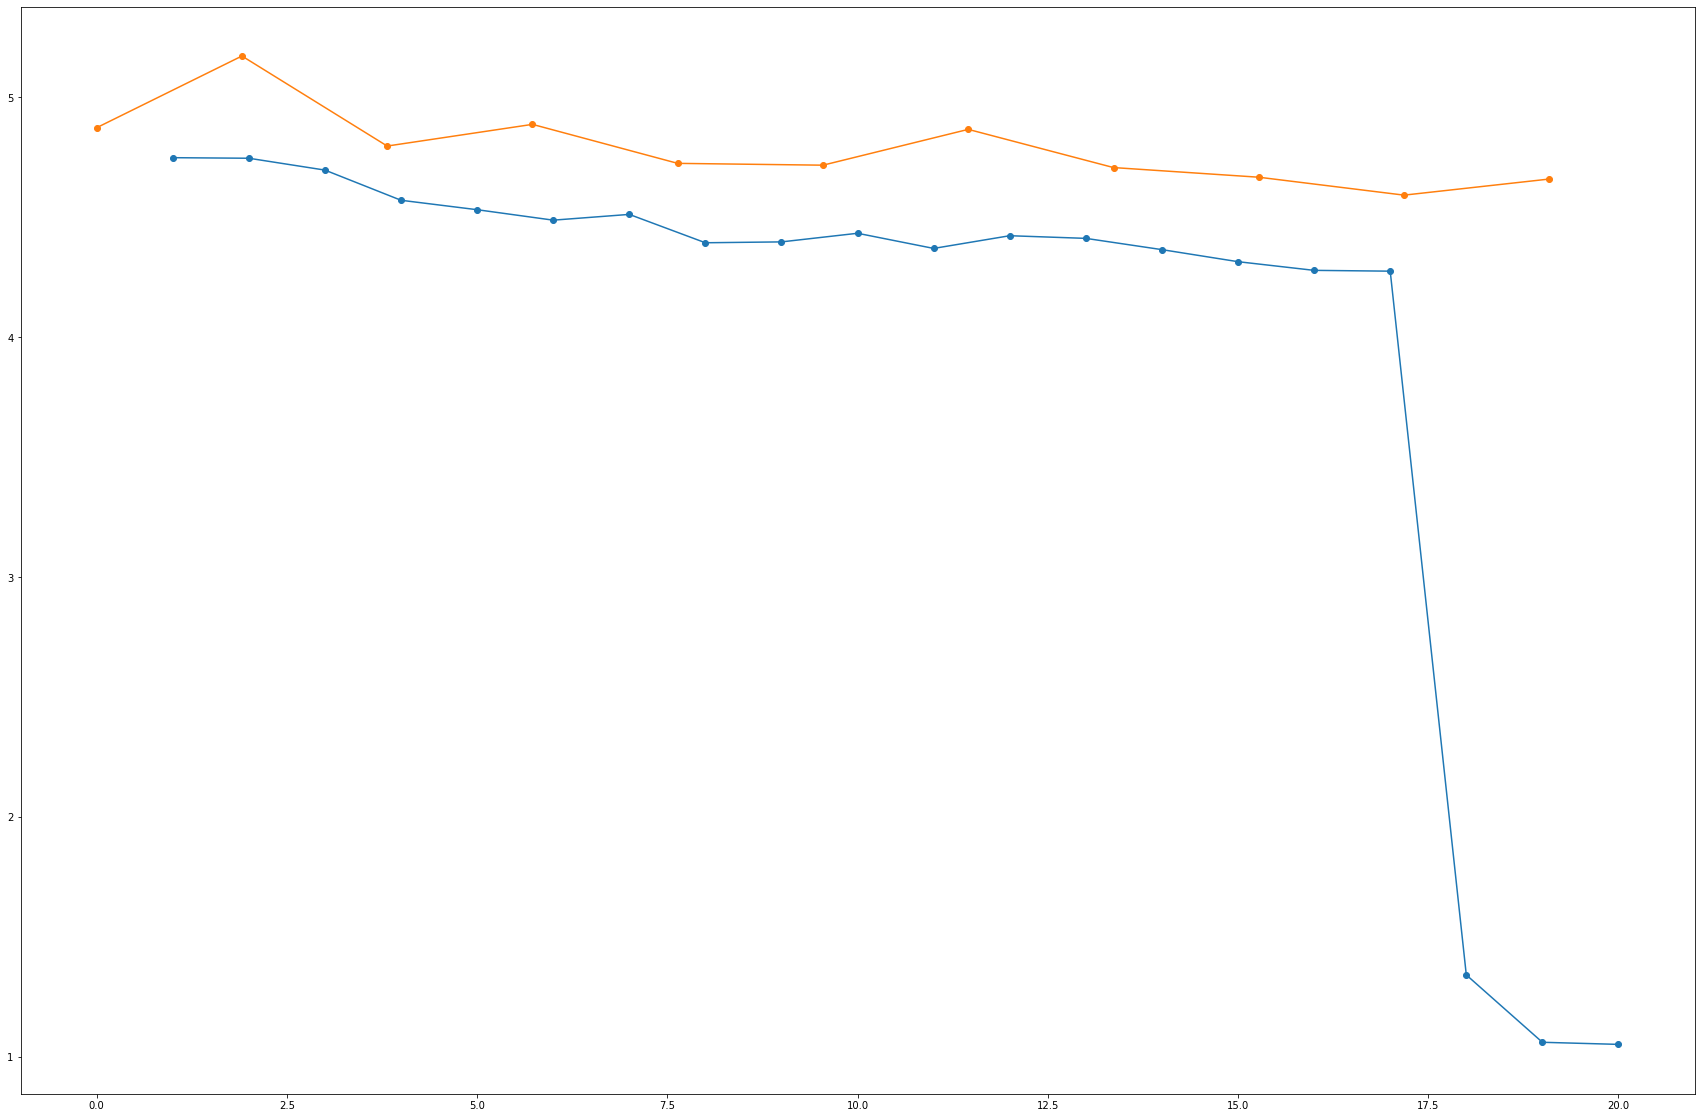

In [192]:
# plt.figure(0)
plt.plot(np.arange(1,nb_epoch),train_losses_epoch[1:],'o-')

plt.plot(np.arange(0,nb_epoch,nb_epoch/len(test_losses_avg)),test_losses_avg,'o-')

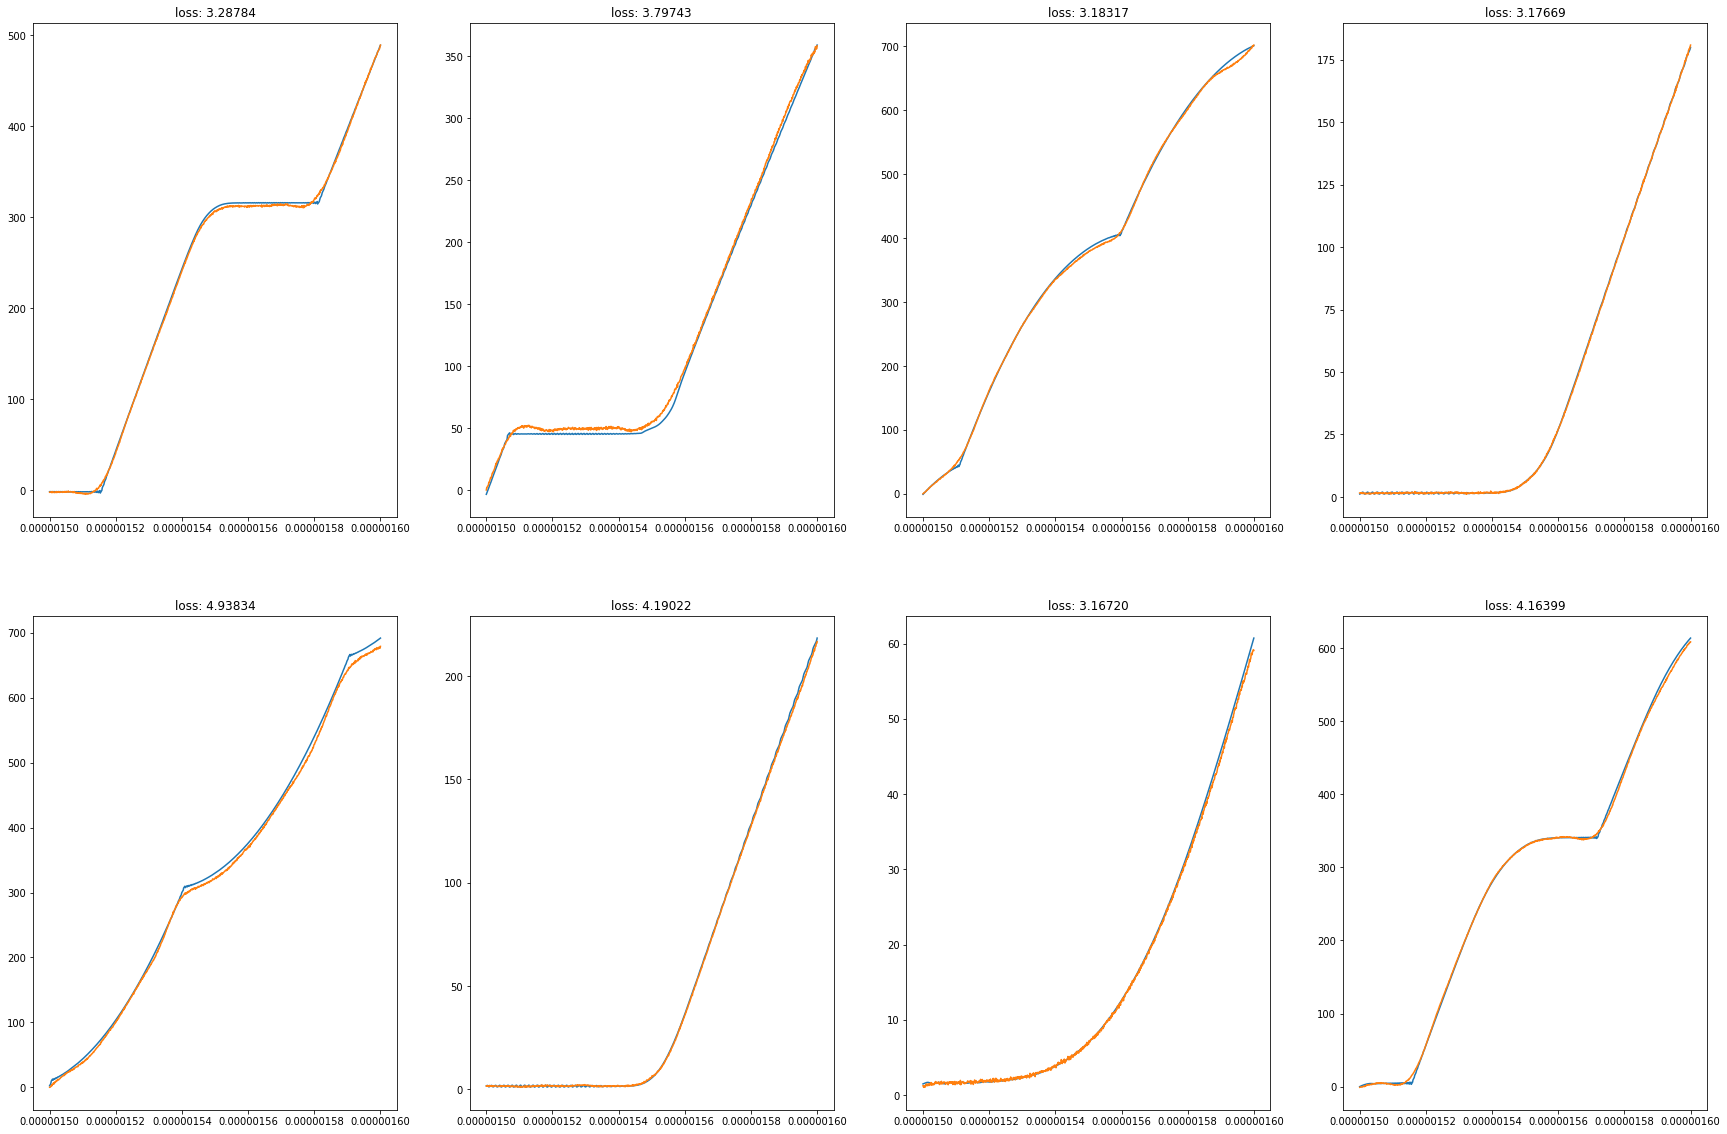

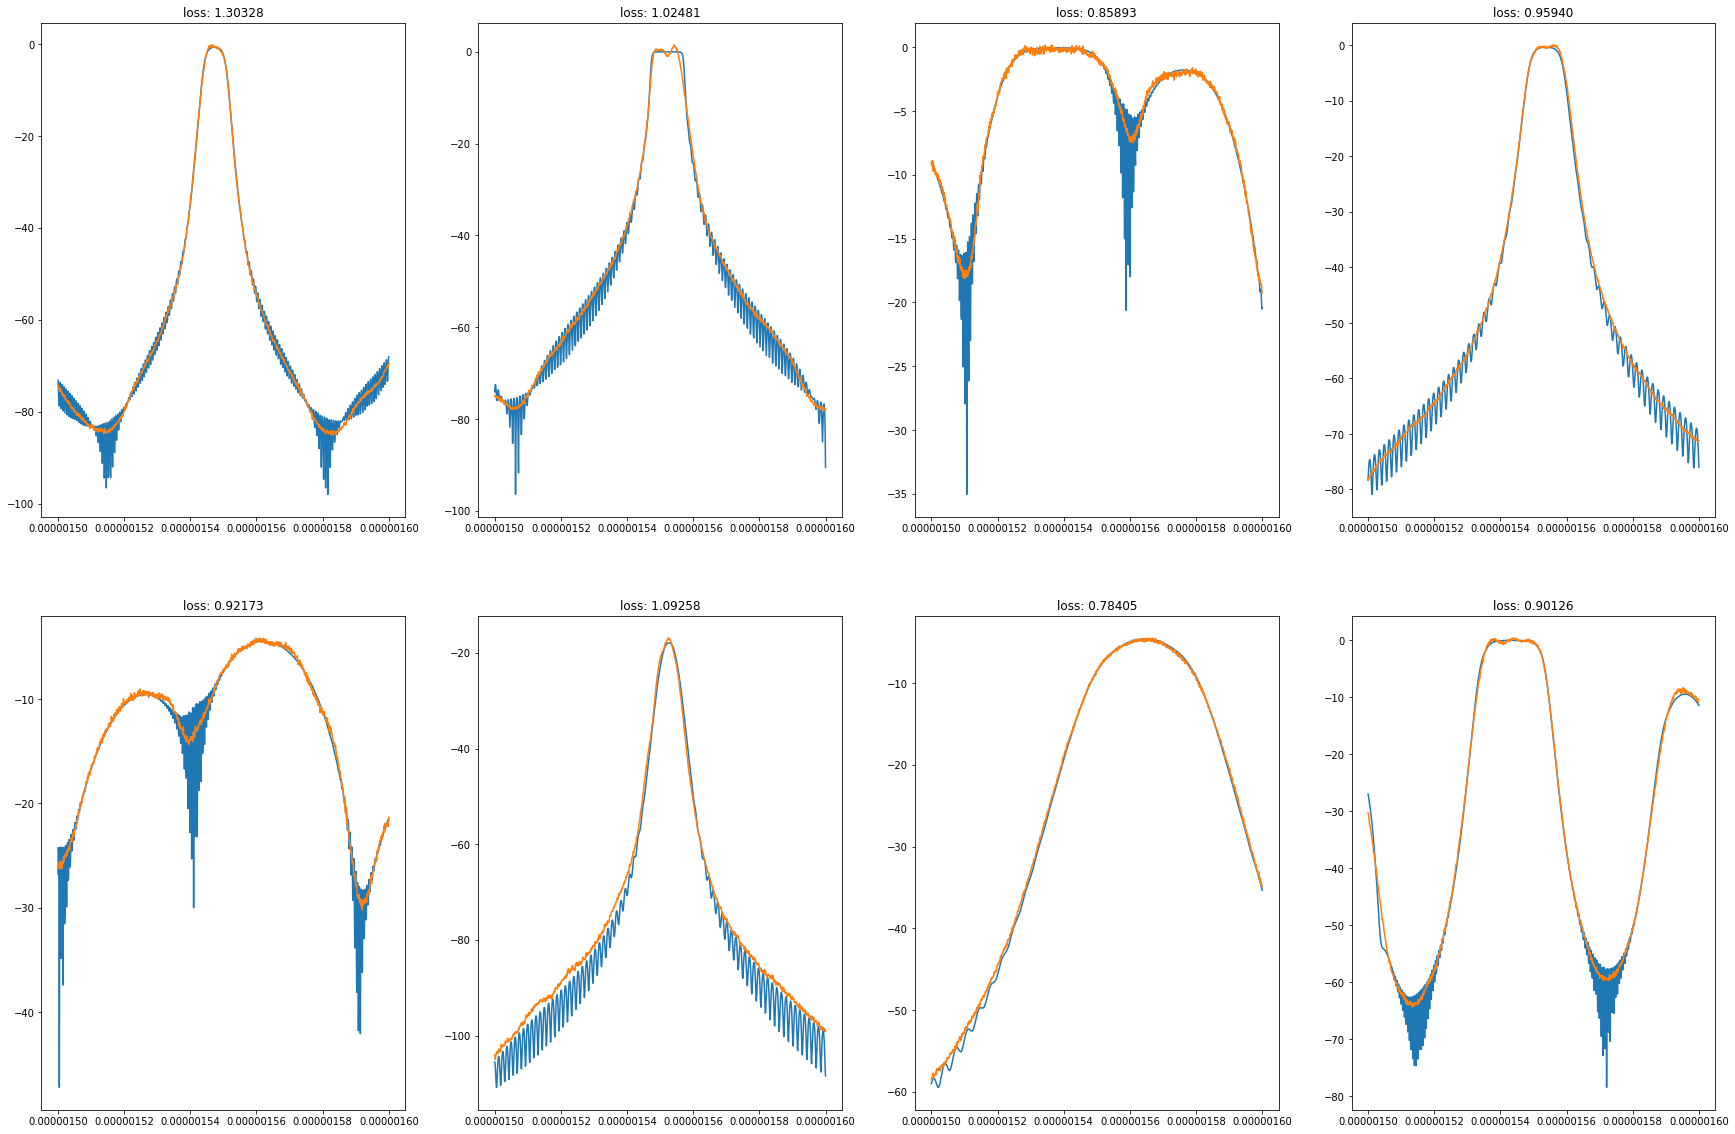

In [193]:
## EVALUATION
# model = DenseNet(1001,batch_size)
# model.load_state_dict(torch.load("DenseNet_t0_dB"))
model.eval()



all_predictions1 = []
all_target1 = []
all_predictions2 = []
all_target2 = []
all_loss1 = []
all_loss2 = []
for i_batch, batch in enumerate(test_loader):
    images, targets = batch
    images = images.to(device)
    targets = targets.type(torch.FloatTensor)
    targets = targets.to(device) 
    with torch.no_grad():
        target1 = targets[:,0:1001]
        target2 = targets[:,1001:2002]
        predictions1,predictions2 = model.forward(images)
        loss1 = criterion(predictions1, target1) 
        loss2 = criterion(predictions2, target2)        
        loss = loss1+loss2            
    all_loss1.append(loss1.item())
    all_loss2.append(loss2.item())
    all_predictions1.append(predictions1.cpu().numpy())
    all_target1.append(target1.cpu().numpy())
    all_predictions2.append(predictions2.cpu().numpy())
    all_target2.append(target2.cpu().numpy())


jd =0
lambda_ = np.linspace(1500e-9,1600e-9,1001)
matplotlib.rcParams['figure.figsize'] = (30, 20)
fig, subfigs = plt.subplots(2, 4)
idx = np.random.randint(0,len(test_loader),8)
for subfig,kd in zip(subfigs.reshape(-1),idx): 
        subfig.plot(lambda_,(all_target2[kd][jd]))
        subfig.plot(lambda_,(all_predictions2[kd][jd]))  
        subfig.set_title('loss: {:.5f}'.format(all_loss2[kd]))
plt.show()
fig, subfigs = plt.subplots(2, 4)       
for subfig,kd in zip(subfigs.reshape(-1),idx): 
        subfig.plot(lambda_,(all_target1[kd][jd]))
        subfig.plot(lambda_,(all_predictions1[kd][jd]))  
        subfig.set_title('loss: {:.5f}'.format(all_loss1[kd]))
plt.show()
